Compute Device: cuda
Files already downloaded and verified


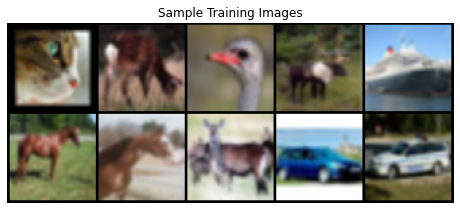

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
from tqdm import tqdm

compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute Device:', compute_device)
learnRate = 0.0002
batchSz = 32
imgSz = 64
imgChannels = 3
dimZ = 100
epochsNum = 25
discFeat = 64
genFeat = 64
clipWeight = 0.01
criticIterations = 2

cifar_dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                                 transform=transforms.Compose([
                                     transforms.Resize(64),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                 ]))
data_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=batchSz,
                                          shuffle=True, num_workers=2)
# Display training images
training_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(training_batch[0].to(compute_device)[:10], nrow=5, padding=2, normalize=True).cpu(), (1, 2, 0)))


In [2]:

def set_initial_weights(mod):
    for module in mod.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)

class Critic(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Critic, self).__init__()
        self.critic_layers = nn.Sequential(
            nn.Conv2d(img_channels, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._critic_block(features_d, features_d * 2, 4, 2, 1),
            self._critic_block(features_d * 2, features_d * 4, 4, 2, 1),
            self._critic_block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _critic_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.critic_layers(x)

critic = Critic(imgChannels, discFeat).to(compute_device)
set_initial_weights(critic)

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()
        self.gen_layers = nn.Sequential(
            self._gen_block(z_dim, features_g * 16, 4, 1, 0),
            self._gen_block(features_g * 16, features_g * 8, 4, 2, 1),
            self._gen_block(features_g * 8, features_g * 4, 4, 2, 1),
            self._gen_block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen_layers(x)

gen = Generator(dimZ, imgChannels, genFeat).to(compute_device)
set_initial_weights(gen)

optimizer_gen = optim.RMSprop(gen.parameters(), lr=learnRate)
optimizer_critic = optim.RMSprop(critic.parameters(), lr=learnRate)
static_noise = torch.randn(batchSz, dimZ, 1, 1).to(compute_device)
iteration = 0

gen.train(), critic.train()

# Implement FID
class InceptionFeatureExtractor(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionFeatureExtractor, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block 0
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)
            if idx == self.last_needed_block:
                break
        return outp

block_idx = InceptionFeatureExtractor.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionFeatureExtractor([block_idx])
inception_model = inception_model.cuda()

/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jkoduri/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import numpy as np
from scipy import linalg

def calc_activation_stats(images, model, batch_sz=128, dims=2048, use_cuda=False):
    model.eval()
    activations = np.empty((len(images), dims))
    if use_cuda:
        batch = images.cuda()
    else:
        batch = images
    predictions = model(batch)[0]
    if predictions.size(2) != 1 or predictions.size(3) != 1:
        predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))
    activations = predictions.cpu().data.numpy().reshape(predictions.size(0), -1)
    mean_act = np.mean(activations, axis=0)
    cov_act = np.cov(activations, rowvar=False)
    return mean_act, cov_act

def calc_frechet_distance(mu1, cov1, mu2, cov2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)

    # Symmetrizing and stabilizing the covariance matrices
    cov1 = (cov1 + cov1.T) / 2 + np.eye(cov1.shape[0]) * eps
    cov2 = (cov2 + cov2.T) / 2 + np.eye(cov2.shape[0]) * eps

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component found in sqrt of product')
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * tr_covmean)

def calculate_fretchet(real_images, fake_images, model):
    mu1, sigma1 = calc_activation_stats(real_images, model, use_cuda=True)
    mu2, sigma2 = calc_activation_stats(fake_images, model, use_cuda=True)
    fid_score = calc_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_score

In [4]:
generator_losses = []
critic_losses = []
disc_losses_practical = []
image_list = []
iteration_counter = 0
fid_scores = []

current_epoch = 0
while current_epoch < epochsNum:
    current_epoch += 1
    for batch_index, data in tqdm(enumerate(data_loader, 0)):
        real_images = data[0].to(compute_device)
        current_batch_size = real_images.shape[0]

        for _ in range(criticIterations):
            noise_vector = torch.randn(current_batch_size, dimZ, 1, 1).to(compute_device)
            fake_images = gen(noise_vector)
            critic_real = critic(real_images).reshape(-1)
            critic_fake = critic(fake_images).reshape(-1)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            optimizer_critic.step()

            # Clamping critic weights
            for p in critic.parameters():
                p.data.clamp_(-clipWeight, clipWeight)

        generator_output = critic(fake_images).reshape(-1)
        generator_loss = -torch.mean(generator_output)
        gen.zero_grad()
        generator_loss.backward()
        optimizer_gen.step()

        generator_losses.append(generator_loss.detach().cpu())
        critic_losses.append(critic_loss.detach().cpu())

    with torch.no_grad():
        generated_images = gen(static_noise).detach().cpu()
    image_list.append(utils.make_grid(generated_images[:10], nrow=5, padding=2, normalize=True))

    fid = calculate_fretchet(real_images, generated_images, inception_model)
    fid_scores.append(fid)

    print(f'Epoch [{current_epoch}/{epochsNum}] Loss Critic: {critic_loss:.3f}, Loss Generator: {generator_loss:.3f}, FID: {fid:.3f}')

1563it [01:26, 18.12it/s]


Epoch [1/25] Loss Critic: -0.435, Loss Generator: 0.530, FID: 339.929


1563it [01:19, 19.67it/s]


Epoch [2/25] Loss Critic: -0.412, Loss Generator: 0.569, FID: 275.295


1563it [01:19, 19.64it/s]


Epoch [3/25] Loss Critic: -0.356, Loss Generator: 0.308, FID: 283.759


1563it [01:19, 19.67it/s]


Epoch [4/25] Loss Critic: -0.307, Loss Generator: -0.018, FID: 298.451


1563it [01:19, 19.68it/s]


Epoch [5/25] Loss Critic: -0.274, Loss Generator: 0.327, FID: 283.066


1563it [01:19, 19.69it/s]


Epoch [6/25] Loss Critic: -0.205, Loss Generator: 0.140, FID: 296.566


1563it [01:19, 19.70it/s]


Epoch [7/25] Loss Critic: -0.072, Loss Generator: 0.238, FID: 314.782


1563it [01:19, 19.66it/s]


Epoch [8/25] Loss Critic: -0.049, Loss Generator: 0.366, FID: 305.521


1563it [01:19, 19.62it/s]


Epoch [9/25] Loss Critic: -0.133, Loss Generator: 0.230, FID: 287.425


1563it [01:19, 19.63it/s]


Epoch [10/25] Loss Critic: -0.440, Loss Generator: 0.420, FID: 286.856


1563it [01:19, 19.68it/s]


Epoch [11/25] Loss Critic: -0.087, Loss Generator: 0.117, FID: 295.742


1563it [01:19, 19.62it/s]


Epoch [12/25] Loss Critic: -0.196, Loss Generator: 0.224, FID: 333.539


1563it [01:19, 19.69it/s]


Epoch [13/25] Loss Critic: -0.106, Loss Generator: 0.122, FID: 297.548


1563it [01:19, 19.68it/s]


Epoch [14/25] Loss Critic: -0.024, Loss Generator: -0.067, FID: 330.784


1563it [01:19, 19.63it/s]


Epoch [15/25] Loss Critic: -0.161, Loss Generator: 0.061, FID: 318.563


1563it [01:19, 19.64it/s]


Epoch [16/25] Loss Critic: -0.064, Loss Generator: 0.073, FID: 320.250


1563it [01:19, 19.64it/s]


Epoch [17/25] Loss Critic: -0.422, Loss Generator: 0.476, FID: 312.887


1563it [01:19, 19.65it/s]


Epoch [18/25] Loss Critic: -0.145, Loss Generator: 0.329, FID: 302.012


1563it [01:19, 19.65it/s]


Epoch [19/25] Loss Critic: -0.091, Loss Generator: 0.246, FID: 319.434


1563it [01:19, 19.66it/s]


Epoch [20/25] Loss Critic: -0.222, Loss Generator: 0.176, FID: 309.078


1563it [01:19, 19.67it/s]


Epoch [21/25] Loss Critic: 0.024, Loss Generator: -0.023, FID: 327.139


1563it [01:19, 19.69it/s]


Epoch [22/25] Loss Critic: 0.018, Loss Generator: 0.080, FID: 332.516


1563it [01:19, 19.65it/s]


Epoch [23/25] Loss Critic: -0.224, Loss Generator: 0.133, FID: 296.139


1563it [01:19, 19.66it/s]


Epoch [24/25] Loss Critic: -0.217, Loss Generator: 0.261, FID: 315.439


1563it [01:19, 19.63it/s]


Epoch [25/25] Loss Critic: -0.213, Loss Generator: 0.106, FID: 307.148


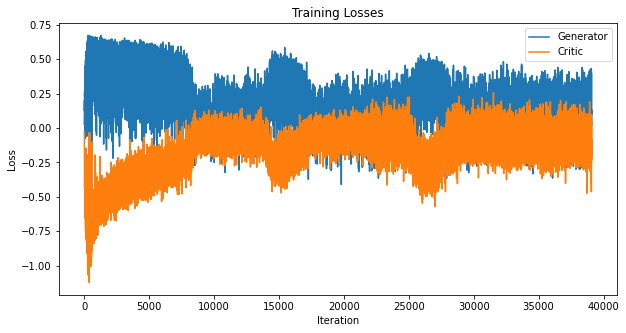

In [5]:
plt.figure(figsize=(10,5))
plt.title("Training Losses")
plt.plot(generator_losses, label="Generator")
plt.plot(critic_losses, label="Critic")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

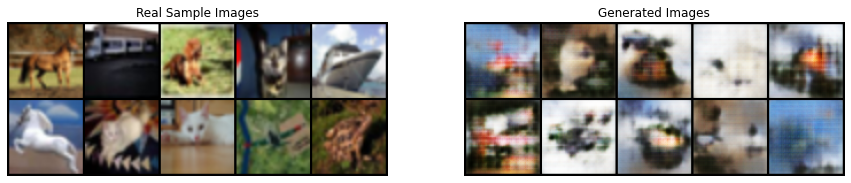

In [6]:
average_gen_loss = np.mean(generator_losses)
average_critic_loss = np.mean(critic_losses)

training_batch = next(iter(data_loader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(training_batch[0].to(compute_device)[:10], nrow=5, padding=2, normalize=True).cpu(), (1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("fake Images")
plt.imshow(np.transpose(utils.make_grid(image_list[-1].to(compute_device), nrow=5, padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

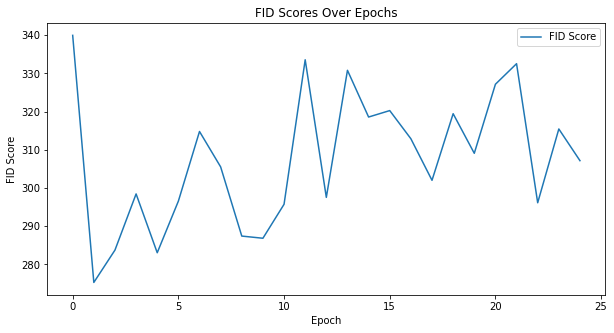

In [7]:
plt.figure(figsize=(10,5))
plt.title("FID Scores Over Epochs")
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

In [11]:
np.mean(fid_scores), fid_scores[-1]

(307.5946901224614, 307.14755826828593)